# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．
1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
!rm NewsAggregatorDataset.zip
!wget --no-check-certificate -q "https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip"
!unzip -n NewsAggregatorDataset.zip
!rm -rf __MACOSX

Archive:  NewsAggregatorDataset.zip
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
news = pd.read_csv('newsCorpora.csv', sep="\t", header=None, names=["ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"],index_col="ID")
news = news.query('PUBLISHER in ["Reuters","Huffington Post","Businessweek", "Contactmusic.com", "Daily Mail"]')
news = news.sample(frac=1,random_state=0)
news.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,b,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,e,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,b,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,e,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-06-1...,Businessweek,b,dXVU3KhKpHSxleMNmc46pQj6e5zwM,www.businessweek.com,1403113194649


※問題に書いてあるのでsplitしているが、処理が面倒なので前処理は元のファイルを使う

In [3]:
from sklearn.model_selection import train_test_split
test_valid, train = train_test_split(news, test_size=0.8, random_state=0)
test, valid = train_test_split(test_valid, test_size=0.5, random_state=0)

In [4]:
train.to_csv("train.txt",sep="\t",header=False)
valid.to_csv("valid.txt",sep="\t",header=False)
test.to_csv("test.txt",sep="\t",header=False)

In [5]:
!wc -l train.txt
!wc -l valid.txt
!wc -l test.txt

10682 train.txt
1334 valid.txt
1334 test.txt


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ（このファイルは後に問題70で再利用する）． ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのスペース区切り形式とせよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

#### データの確認 => data_feature.ipynbにて

今回は時間が足りなかったので、spacyかnltkのtokenizer,lemmatizerを使用して切り出した語幹のunigramとurlから切り出した語をカラムにする<br>
chapter8では、以下のnotebookを使用することにする

+ data_features_url.ipynb : urlのパース用
+ data_features_text.ipynb : 自分でurlとtitleを色々しようと思ったけど、しんどくて途中でやめた(一応残している)
+ data_features_text_nltk.ipynb : nltkを使って固有表現とかを使おうとしている(セコ？)
+ data_features_text_spacy.ipynb : spacyを使って固有表現とかを使おうとしている(セコ？)
+ data_features_text_mendo.ipynb : よく考えたらtitleなんて出てくる単語限られてるからunigramだけでいいじゃん...(面倒かったので採用)

In [6]:
news = pd.read_csv('news_mod_spacy_simple.csv',index_col="ID")

In [7]:
news

,CATEGORY,PUBLISHER,genre,TITLE,uri,story,uri_features,month,date,day,...,f_anthrax,f_arquett,f_down,f_mh17,f_vma,f_prinz,f_duff,f_iliad,f_horton,f_bucket
ID,,,,,,,,,,,,,,,,,,,,,
13,b,Reuters,article,Europe reaches crunch point on banking union,eu banks resoluton,0,INL6N0M71NJ,3,10,Mon,...,0,0,0,0,0,0,0,0,0,0
14,b,Reuters,article,ECB FOCUS Stronger euro drowns out ECB's messa...,ecb policy,0,INL6N0M71K3,3,10,Mon,...,0,0,0,0,0,0,0,0,0,0
20,b,Businessweek,news,"Euro Anxieties Wane as Bunds Top Treasuries, S...",german bonds beat treasuries with yield spread...,0,NaN,3,10,Mon,...,0,0,0,0,0,0,0,0,0,0
21,b,Businessweek,news,Noyer Says Strong Euro Creates Unwarranted Eco...,noyer says stronger euro creates unwarranted p...,0,NaN,3,10,Mon,...,0,0,0,0,0,0,0,0,0,0
30,b,Reuters,article,REFILE Bad loan triggers key feature in ECB ba...,eurozone bank tests,0,INL6N0M71F0,3,10,Mon,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422819,m,Huffington Post,hp,UN: Ebola Could Eventually Infect 20000 People,ebola 20000 people,4577,NaN,8,28,Thu,...,0,0,0,0,0,0,0,0,0,0
422820,m,Reuters,article,"Ebola toll tops 1550, continues to accelerate ...",health ebola toll,4577,INL5N0QY2GR,8,28,Thu,...,0,0,0,0,0,0,0,0,0,0
422821,m,Reuters,article,"UPDATE 1 Ebola toll tops 1550, outbreak accele...",health ebola toll,4577,INL5N0QY2J7,8,28,Thu,...,0,0,0,0,0,0,0,0,0,0


In [8]:
news = news.drop(['TITLE','uri','title_lemma','uri_lemma'],axis=1)

In [9]:
news_ = news
news_ = pd.concat([news_.drop(['PUBLISHER'],axis=1),pd.get_dummies(news['PUBLISHER'],prefix="pub")],axis=1)
news_ = pd.concat([news_.drop(['genre'],axis=1),pd.get_dummies(news['genre'],prefix="genre")],axis=1)
news_ = pd.concat([news_.drop(['story'],axis=1),pd.get_dummies(news['story'],prefix="story")],axis=1)
news_ = pd.concat([news_.drop(['uri_features'],axis=1),pd.get_dummies(news['uri_features'],prefix="uri_f")],axis=1)
news_ = pd.concat([news_.drop(['day'],axis=1),pd.get_dummies(news['day'],prefix="day")],axis=1)

In [10]:
news_

,CATEGORY,month,date,time,ts,f_eu,f_bank,f_union,f_europ,f_reach,...,uri_f_USZXN0R7A05,uri_f_USZXN0R7A2I,uri_f_pictures-slideshow,day_Fri,day_Mon,day_Sat,day_Sun,day_Thu,day_Tue,day_Wed
ID,,,,,,,,,,,,,,,,,,,,,
13,b,3,10,0,8640.0,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
14,b,3,10,0,8640.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
20,b,3,10,0,8640.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
21,b,3,10,0,8640.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
30,b,3,10,0,8640.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422819,m,8,28,0,254880.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
422820,m,8,28,0,254880.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
422821,m,8,28,0,254880.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
from sklearn.model_selection import train_test_split
test_valid, train = train_test_split(news_, test_size=0.8, random_state=0)
test, valid = train_test_split(test_valid, test_size=0.5, random_state=0)

In [12]:
train.to_csv("train.txt")
valid.to_csv("valid.txt")
test.to_csv("test.txt")

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [13]:
train_ = pd.read_csv('train.txt',index_col="ID")
test_  = pd.read_csv('test.txt',index_col="ID")
valid_ = pd.read_csv('valid.txt',index_col="ID")

In [14]:
change = lambda cate: ['b','e','m','t'].index(cate)

In [15]:
# remo = ['date','month','time',"ts","Contactmusic.com","Reuters"] # これでF2は良くなった

- \_なし: l2ノルム、カラム全て
- \_:  l1ノルム、カラム全て
- \_\_: l1ノルム、カラムstory除く
- \_\_\_: l1ノルム、カラムstory,uri_f除く


In [16]:
train_X, train_Y = train_.drop(["CATEGORY"],axis=1), train_["CATEGORY"].apply(change)
test_X, test_Y =   test_.drop(["CATEGORY"],axis=1),  test_["CATEGORY"].apply(change)
valid_X, valid_Y = valid_.drop(["CATEGORY"],axis=1), valid_["CATEGORY"].apply(change)

In [17]:
_train_X, _test_X, _valid_X = train_X, test_X, valid_X

In [18]:
drop = test_.columns[test_.columns.str.startswith('story_')]
__train_X = _train_X.drop(drop,axis=1)
__test_X  = _test_X.drop(drop,axis=1)
__valid_X = _valid_X.drop(drop,axis=1)

In [19]:
drop = test_.columns[test_.columns.str.startswith('uri_f_')]
___train_X = __train_X.drop(drop,axis=1)
___test_X  = __test_X.drop(drop,axis=1)
___valid_X = __valid_X.drop(drop,axis=1)

In [20]:
from functools import reduce
drop = test_.columns[reduce(lambda x,y:x|y, map(lambda x:test_.columns.str.startswith(x), ['genre_','pub_','day_']))] | pd.Index(["month","date",'time', 'ts'])
____train_X = ___train_X.drop(drop,axis=1)
____test_X  = ___test_X.drop(drop,axis=1)
____valid_X = ___valid_X.drop(drop,axis=1)

In [21]:
_____train_X, _____test_X, _____valid_X = ____train_X, ____test_X, ____valid_X

In [22]:
train_Y.value_counts()

0    4493
1    4232
3    1230
2     717
Name: CATEGORY, dtype: int64

In [23]:
from sklearn import linear_model
def lmgen(*,prefix,penalty="l2",solver="lbfgs",n_jobs=4,max_iter=100,C=1.0):
    if penalty == "elasticnet": solver = "saga"
    if penalty == "l1": solver = "liblinear"
    if solver == "liblinear": n_jobs=1
    return linear_model.LogisticRegression(random_state=0,
                                         penalty=penalty,
                                         solver=solver,
                                         n_jobs=n_jobs,
                                         max_iter=100,
                                         C=C
                                        ).fit(eval(f"{prefix}train_X"),train_Y)

In [24]:
lm = lmgen(prefix="")
_lm = lmgen(prefix="_",penalty="l1",C=10000.)
__lm = lmgen(prefix="__",penalty="l1",C=10000.)
___lm = lmgen(prefix="___",penalty="l1",C=10000.)
____lm = lmgen(prefix="____",penalty="l1",C=10000.)
_____lm = lmgen(prefix="_____")

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

全データ使っていいと勘違いしていた。悲しいので他のデータも使う..

In [25]:
def predict(model, x:pd.DataFrame):
    pred = model.predict_proba(x)
    return pred.argmax(axis=1), pred

## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [26]:
# 別の書き方, 代入式を使用
# print("l2ノルム、カラム全て")
# print(skm.accuracy_score(train_Y, (train_pred_Y := predict(lm,train_X)[0])))
# print(skm.accuracy_score(test_Y,  (test_pred_Y  := predict(lm, test_X)[0])))
# print(skm.accuracy_score(valid_Y, (valid_pred_Y := predict(lm,valid_X)[0])))

In [27]:
import sklearn.metrics as skm
def tmp(s, prefix):
    print(s)
    for mode in ["train","valid","test"]:
        exec(f"{prefix}{mode}_pred_Y, _ = predict({prefix}lm, {prefix}{mode}_X)", globals())
        print("> {:<5} : {:.5f}".format(mode,skm.accuracy_score(eval(f"{mode}_Y"), eval(f"{prefix}{mode}_pred_Y"))))

In [28]:
tmp("l2ノルム、カラム全て",prefix="")
tmp("l1ノルム、カラム全て",prefix="_")
tmp("l1ノルム、カラムstory除く",prefix="__")
tmp("l1ノルム、カラムstory,uri_f除く",prefix="___")
tmp("l2ノルム、カラム文字列のみ",prefix="____")

l2ノルム、カラム全て
> train : 0.65470
> valid : 0.65967
> test  : 0.66117
l1ノルム、カラム全て
> train : 1.00000
> valid : 0.96102
> test  : 0.96027
l1ノルム、カラムstory除く
> train : 0.99991
> valid : 0.89580
> test  : 0.89880
l1ノルム、カラムstory,uri_f除く
> train : 0.99944
> valid : 0.90480
> test  : 0.89880
l2ノルム、カラム文字列のみ
> train : 0.99916
> valid : 0.89130
> test  : 0.89655


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

|||
|:-:|:-:|
|TP|FN|
|FP|TN|

In [29]:
def tmp(s, *,prefix):
    print(s)
    for mode in ["train","valid","test"]:
        print(mode)
        print(skm.confusion_matrix(eval(mode+"_Y"),eval(f"{prefix}{mode}_pred_Y")),end="\n\n")

In [30]:
tmp("l2ノルム、カラム全て",prefix="")
tmp("l1ノルム、カラム全て",prefix="_")
tmp("l1ノルム、カラムstory除く",prefix="__")
tmp("l1ノルム、カラムstory,uri_f除く",prefix="___")
tmp("l2ノルム、カラム文字列のみ",prefix="____")

l2ノルム、カラム全て
train
[[4292  201    0    0]
 [1537 2695    0    0]
 [ 490  227    0    0]
 [ 952  278    0    0]]

valid
[[526  20   0   0]
 [184 354   0   0]
 [ 68  26   0   0]
 [120  36   0   0]]

test
[[564  24   0   0]
 [191 318   0   0]
 [ 69  30   0   0]
 [104  34   0   0]]

l1ノルム、カラム全て
train
[[4493    0    0    0]
 [   0 4232    0    0]
 [   0    0  717    0]
 [   0    0    0 1230]]

valid
[[541   4   1   0]
 [  6 531   1   0]
 [ 11   7  73   3]
 [ 11   7   1 137]]

test
[[582   2   0   4]
 [  4 503   0   2]
 [  9  14  76   0]
 [ 14   4   0 120]]

l1ノルム、カラムstory除く
train
[[4492    1    0    0]
 [   0 4232    0    0]
 [   0    0  717    0]
 [   0    0    0 1230]]

valid
[[500  11   5  30]
 [ 16 503   4  15]
 [ 13   6  67   8]
 [ 20   9   2 125]]

test
[[543   7   6  32]
 [ 17 478   4  10]
 [ 12   7  77   3]
 [ 27   8   2 101]]

l1ノルム、カラムstory,uri_f除く
train
[[4489    1    0    3]
 [   1 4231    0    0]
 [   0    0  717    0]
 [   1    0    0 1229]]

valid
[[508   9   6  23]
 [ 17 507 

## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

- 適合率(precision):$\frac{TP}{TP+FP}$
- 再現率(recall):$\frac{TP}{TP+FN}$
- F: $\frac{2RP}{R+P}$
- micro: クラスが関係なく平均
- macro: クラスごとに出して平均

In [31]:
tmp = lambda s, prefix: print(s ,skm.classification_report(valid_Y, eval(f"{prefix}valid_pred_Y")),sep="\n")

In [32]:
tmp("l2ノルム、カラム全て",prefix="")
tmp("l1ノルム、カラム全て",prefix="_")
tmp("l1ノルム、カラムstory除く",prefix="__")
tmp("l1ノルム、カラムstory,uri_f除く",prefix="___")
tmp("l2ノルム、カラム文字列のみ",prefix="____")

l2ノルム、カラム全て
              precision    recall  f1-score   support

           0       0.59      0.96      0.73       546
           1       0.81      0.66      0.73       538
           2       0.00      0.00      0.00        94
           3       0.00      0.00      0.00       156

    accuracy                           0.66      1334
   macro avg       0.35      0.41      0.36      1334
weighted avg       0.57      0.66      0.59      1334

l1ノルム、カラム全て
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       546
           1       0.97      0.99      0.98       538
           2       0.96      0.78      0.86        94
           3       0.98      0.88      0.93       156

    accuracy                           0.96      1334
   macro avg       0.96      0.91      0.93      1334
weighted avg       0.96      0.96      0.96      1334

l1ノルム、カラムstory除く
              precision    recall  f1-score   support

           0       0.91      0.92 

/home/maruyama.y/_/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [33]:
from IPython.display import display
def tmp(s, prefix, top=7):
    train_X = eval(f"{prefix}train_X")
    lm = eval(f"{prefix}lm")
    li = []
    cates = ["business","entertainment","health","science and technology"]
    print(*cates,sep="     ================     ")
    for coef,cate in zip(lm.coef_,cates):
        li.append(pd.DataFrame({"Name":train_X.columns,"Coefficients":coef,"abs_Coefficients":abs(coef)}).sort_values(by='abs_Coefficients',ascending=False)[["Name","Coefficients"]][:top])
    class HorizontalDisplay:
        def __init__(self, *args):
            self.args = args
        def _repr_html_(self):
            return "\n".join('<div style="float: left; padding: 10px;">{}</div>'.format(arg._repr_html_()) for arg in self.args)
    display(HorizontalDisplay(*li))

In [34]:
tmp("l2ノルム、カラム全て",prefix="")
tmp("l1ノルム、カラム全て",prefix="_")
tmp("l1ノルム、カラムstory除く",prefix="__")
tmp("l1ノルム、カラムstory,uri_f除く",prefix="___")
tmp("l2ノルム、カラム文字列のみ",prefix="____")

business     ================     entertainment     ================     health     ================     science and technology


,Name,Coefficients
1,date,0.027297
0,month,0.004015
2849,pub_Reuters,0.002729
2851,genre_article,0.002356
2,time,-0.001537
2868,genre_news,0.001478
2860,genre_hp,-0.001386
,Name,Coefficients
2846,pub_Contactmusic.com,0.001895
2849,pub_Reuters,-0.001697


business     ================     entertainment     ================     health     ================     science and technology


,Name,Coefficients
4670,story_1782,19.120525
3436,story_548,18.374415
3901,story_1013,17.961166
7211,story_4323,17.075621
6073,story_3185,-16.562890
3109,story_221,16.245269
5184,story_2296,16.113162
,Name,Coefficients
7410,story_4522,-18.160756
6082,story_3194,17.827842


business     ================     entertainment     ================     health     ================     science and technology


,Name,Coefficients
5551,uri_f_USBREA450UI,-41.449611
4008,uri_f_INL2N0PQ2CK,-40.783747
6041,uri_f_USL2N0OX08W,-40.016662
6446,uri_f_USL5N0MS1WJ,-38.725068
3804,uri_f_INL2N0OT1HH,-37.171956
3205,uri_f_INL1N0MM1WD,-34.178233
3100,uri_f_INKBN0DF13C,-34.129085
,Name,Coefficients
6044,uri_f_USL2N0OX1B0,36.186572
4990,uri_f_INL6N0NM69X,33.569142


business     ================     entertainment     ================     health     ================     science and technology


,Name,Coefficients
2726,f_nintendo,-57.650985
1943,f_choic,-55.559054
1389,f_courtney,-55.487210
2262,f_whale,-55.484768
2578,f_provid,-52.288978
1414,f_sentenc,-52.162965
2571,f_hole,-51.091535
,Name,Coefficients
1806,f_nasa,-39.671331
1928,f_option,-37.617260


business     ================     entertainment     ================     health     ================     science and technology


,Name,Coefficients
1459,f_solut,54.997190
1385,f_courtney,-47.529993
2574,f_provid,-44.761819
2258,f_whale,-44.018941
2822,f_daimler,-44.006116
1974,f_oculus,-40.307080
2722,f_nintendo,-39.919427
,Name,Coefficients
734,f_lax,24.300935
2804,f_argentina,-22.510916


## 58. 正則化パラメータの変更 & 59. ハイパーパラメータの探索
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．


学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．評価データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．

- 正則化パラメータC = $\frac{1}{\lambda}$($\lambda$:L*正則化項の係数)
- penalty: {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}

In [35]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import random
from tqdm import tqdm

/home/maruyama.y/_/lib/python3.8/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [36]:
def acc(*,prefix,C:float,penalty,solver="lbfgs",n_jobs=4,max_iter=100):
    lm = lmgen(prefix=prefix,penalty=penalty,solver=solver,C=C,n_jobs=n_jobs,max_iter=100)
    return (skm.accuracy_score(eval(f"{mode}_Y"), lm.predict(eval(f"{prefix}{mode}_X"))) for mode in ["train","test","valid"])

In [37]:
def opts(Cs):
    if Cs is None: Cs = {10**i:None for i in range(-3,3)}
    if None in Cs.values(): C = [c[0] for c in Cs.items() if c[1]==None][0]
    else:
        while random.random() < 0.1:
            C = random.sample(Cs.keys(),1)[0]
            Cs.setdefault(C/10,None)
            Cs.setdefault(C*10,None)
        Cs_ = [[k,v] for k,v in Cs.items() if v is not None]
        C = max(Cs_, key=lambda x:x[1]["valid"])[0] # validが最大のもの
        li = sorted(Cs.keys())
        if (a:=li.index(C))!=0:         Cs.setdefault((li[a-1]+C)/2,None)
        else:                           Cs.setdefault(C/10,None)
        if (a:=li.index(C))!=len(li)-1: Cs.setdefault((li[a+1]+C)/2,None)
        else:                           Cs.setdefault(C*10,None)
    return C,Cs

In [38]:
def tmp(s,*,prefix,penalties=['l1','l2'],depth=200,solver="lbfgs"): # penalties = ['l1','l2','elasticnet','none']
    fig = plt.figure(figsize=(7*len(penalties),6))
    fig.suptitle(s)
    for j, penalty in enumerate(penalties):
        _, Cs = opts(None)
        for _ in tqdm(range(depth)):
            C, Cs = opts(Cs)
            train, test, valid = acc(prefix=prefix,C=C,penalty=penalty,solver=solver)
            Cs[C] = {"train":train, "test":test, "valid":valid}
            if penalty == "none": break
        Cs = [[k,v] for k,v in Cs.items() if v is not None]
        Cs = sorted(Cs, key=lambda c:c[0])
        print("penalty: {}, max valid: {}".format(penalty, max(Cs,key=lambda c:c[1]["valid"])))
        sub = fig.add_subplot(1,len(penalties),j+1)
        sub.set_title(penalty)
        plt.xscale('log')
        for mode in ["train","valid","test"]: sub.plot([c[0] for c in Cs],[c[1][mode] for c in Cs], label=mode)
    plt.legend()
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

penalty: l1, max valid: [21250.0, {'train': 1.0, 'test': 0.9647676161919041, 'valid': 0.9632683658170914}]


100%|██████████| 200/200 [08:40<00:00,  2.60s/it]


penalty: l2, max valid: [0.0549945068359375, {'train': 0.6899362818590704, 'test': 0.6964017991004497, 'valid': 0.6881559220389805}]


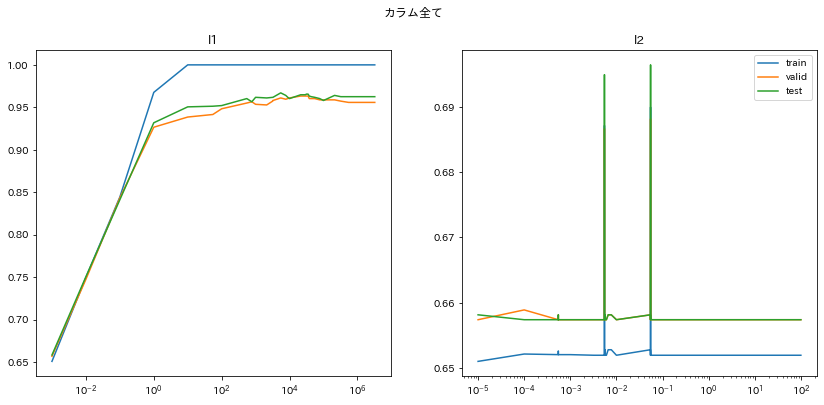

  0%|          | 0/200 [00:00<?, ?it/s]

penalty: l1, max valid: [3.3818359375, {'train': 0.9941904047976012, 'test': 0.9257871064467766, 'valid': 0.9235382308845578}]


100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


penalty: l2, max valid: [8.625390625000001e-05, {'train': 0.6521739130434783, 'test': 0.6574212893553223, 'valid': 0.658920539730135}]


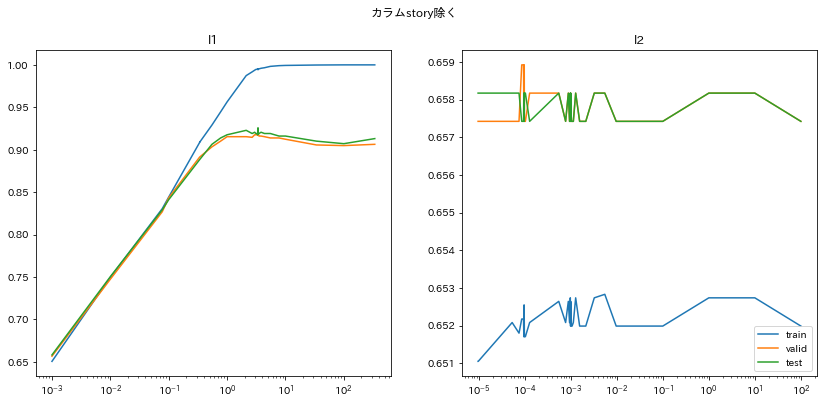

  0%|          | 0/200 [00:00<?, ?it/s]

penalty: l1, max valid: [3.2401123046875, {'train': 0.9913793103448276, 'test': 0.9212893553223388, 'valid': 0.9190404797601199}]


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


penalty: l2, max valid: [0.1011260987375863, {'train': 0.6957458770614693, 'test': 0.7031484257871065, 'valid': 0.6934032983508246}]


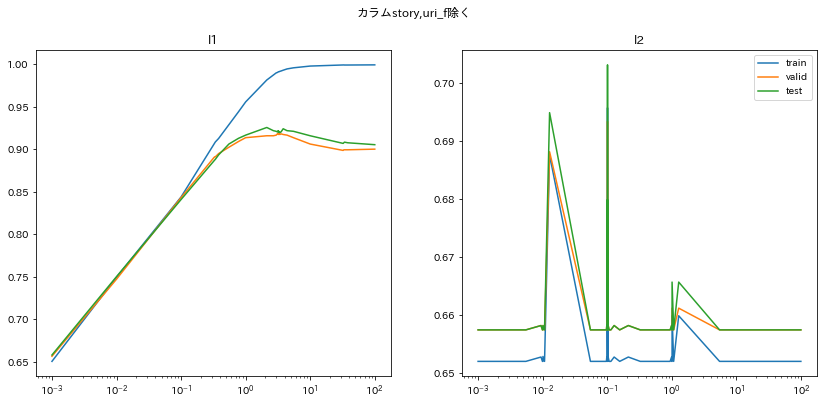

  0%|          | 0/200 [00:00<?, ?it/s]

penalty: l1, max valid: [2.6962890625, {'train': 0.985476011994003, 'test': 0.9160419790104948, 'valid': 0.9122938530734632}]


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]


penalty: l2, max valid: [0.94375, {'train': 0.9672038980509745, 'test': 0.9235382308845578, 'valid': 0.9175412293853074}]


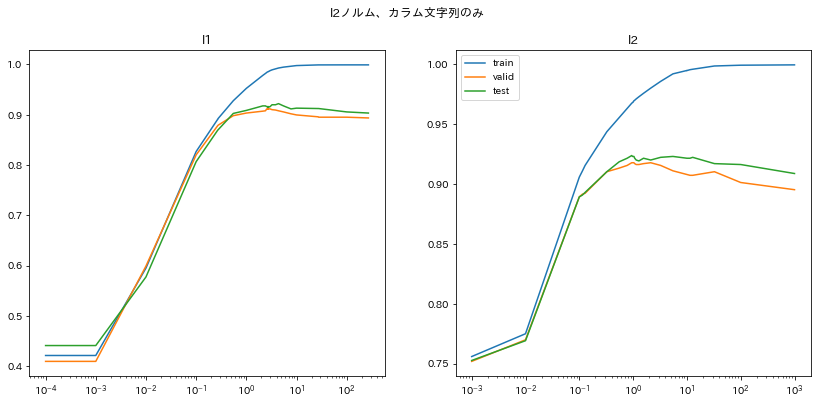

In [39]:
tmp("カラム全て",prefix="",solver="liblinear")
tmp("カラムstory除く",prefix="__",solver="liblinear")
tmp("カラムstory,uri_f除く",prefix="___",solver="liblinear")
tmp("l2ノルム、カラム文字列のみ",prefix="____",solver="liblinear")

In [40]:
# 59は、学習アルゴリズムまでイロイロ試すのは時間的にきつそう。58でLRのパラメータを探索したとする....

100%|██████████| 200/200 [4:57:19<00:00, 89.20s/it]  


penalty: l2, max valid: [0.0032410736083984372, {'train': 0.6611694152923538, 'test': 0.6679160419790104, 'valid': 0.6664167916041979}]


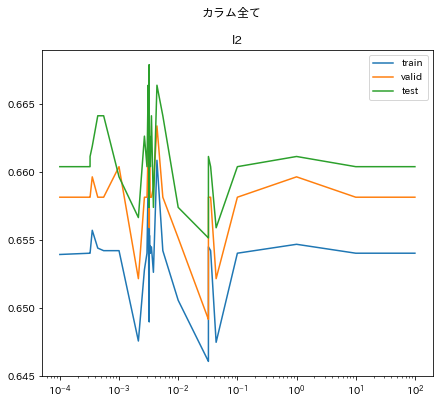

100%|██████████| 200/200 [2:53:17<00:00, 51.99s/it]  


penalty: l2, max valid: [0.003144290924072266, {'train': 0.6592016491754122, 'test': 0.6656671664167916, 'valid': 0.664167916041979}]


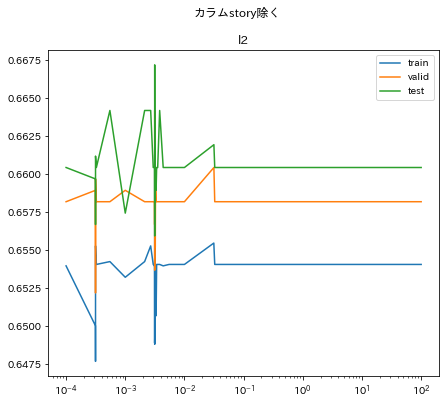

100%|██████████| 200/200 [1:16:08<00:00, 22.84s/it]


penalty: l2, max valid: [0.0010708532333374024, {'train': 0.6592953523238381, 'test': 0.6656671664167916, 'valid': 0.664167916041979}]


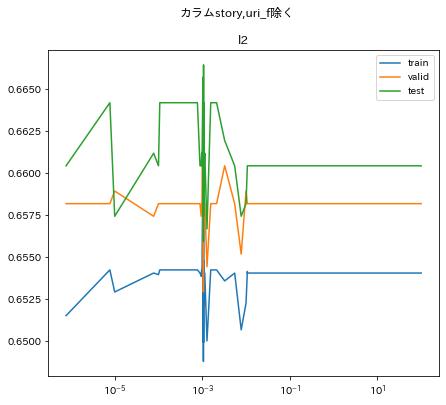

100%|██████████| 200/200 [1:13:04<00:00, 21.92s/it]


penalty: l2, max valid: [1.28125, {'train': 0.9826649175412294, 'test': 0.9250374812593704, 'valid': 0.9145427286356822}]


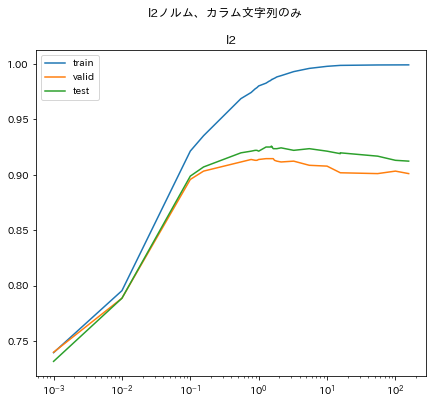

In [41]:
tmp("カラム全て",prefix="",penalties=['l2'])
tmp("カラムstory除く",prefix="__",penalties=['l2'])
tmp("カラムstory,uri_f除く",prefix="___",penalties=['l2'])
tmp("l2ノルム、カラム文字列のみ",prefix="____",penalties=['l2'])